# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *
from metrics import *

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:35000]
    y_subset = y_train[:35000]
    
    # Create KNN graph
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")
    
    return data



data = main()
generate_train_test(data)

X = data.x.numpy()

local_metrics = LocalMetric()


# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17110706865787506
Epoch 10, Loss: 0.06283004581928253
Epoch 20, Loss: 0.046620264649391174
Epoch 30, Loss: 0.039166804403066635
Epoch 40, Loss: 0.032078079879283905
Epoch 50, Loss: 0.029382478445768356
Epoch 60, Loss: 0.026415351778268814
Epoch 70, Loss: 0.02415836974978447
Epoch 80, Loss: 0.0230709295719862
Epoch 90, Loss: 0.02266533486545086
Epoch 100, Loss: 0.021706027910113335
Epoch 110, Loss: 0.02086596190929413
Epoch 120, Loss: 0.020211953669786453
Epoch 130, Loss: 0.020113274455070496
Epoch 140, Loss: 0.01910548098385334
Epoch 150, Loss: 0.021892422810196877
Epoch 160, Loss: 0.01950492337346077
Epoch 170, Loss: 0.01871975138783455
Epoch 180, Loss: 0.018009787425398827
Epoch 190, Loss: 0.01761639304459095
Epoch 0, Loss: 4.124024391174316
Epoch 10, Loss: 1.041128396987915
Epoch 20, Loss: 0.8236745595932007
Epoch 30, Loss: 0.736464262008667
Epoch 40, Loss: 0.7008664608001709
Epoch 50, Loss: 0.6644985675811768
Epoch 60, Loss: 0.6476917266845703
Epoch 70, Loss: 0.628

In [3]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [4]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8085


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862950801849365
Epoch: 20, Loss: 1.386298656463623
Epoch: 30, Loss: 1.386301040649414
Epoch: 40, Loss: 1.38630211353302
Epoch: 50, Loss: 1.3863029479980469
Epoch: 60, Loss: 1.3863030672073364
Epoch: 70, Loss: 1.3863030672073364
Epoch: 80, Loss: 1.3863029479980469
Epoch: 90, Loss: 1.3863028287887573
Epoch: 100, Loss: 1.3863024711608887
Epoch 0, Loss: 2.3036816120147705
Epoch 10, Loss: 2.3020944595336914
Epoch 20, Loss: 2.301953077316284
Epoch 30, Loss: 2.3018734455108643
Epoch 40, Loss: 2.3014330863952637
Epoch 50, Loss: 2.301100730895996
Epoch 60, Loss: 2.3004066944122314
Epoch 70, Loss: 2.3004932403564453
Epoch 80, Loss: 2.3000471591949463
Epoch 90, Loss: 2.299588203430176


## 

In [6]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1090


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [7]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3649781942367554
Epoch: 20, Loss: 1.3667123317718506
Epoch: 30, Loss: 1.3449268341064453
Epoch: 40, Loss: 1.329089879989624
Epoch: 50, Loss: 1.3113536834716797
Epoch: 60, Loss: 1.2853569984436035
Epoch: 70, Loss: 1.2565128803253174
Epoch: 80, Loss: 1.2267796993255615
Epoch: 90, Loss: 1.2041127681732178
Epoch: 100, Loss: 1.1842281818389893
Epoch 0, Loss: 2.321316719055176
Epoch 10, Loss: 2.0722765922546387
Epoch 20, Loss: 2.0271620750427246
Epoch 30, Loss: 1.9978402853012085
Epoch 40, Loss: 1.9893791675567627
Epoch 50, Loss: 1.976999282836914
Epoch 60, Loss: 1.9755816459655762
Epoch 70, Loss: 1.970391869544983
Epoch 80, Loss: 1.9678438901901245
Epoch 90, Loss: 1.9604674577713013


## 

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.2425


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [10]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862943649291992
Epoch: 20, Loss: 1.3862943649291992
Epoch: 30, Loss: 1.3862943649291992
Epoch: 40, Loss: 1.3862943649291992
Epoch: 50, Loss: 1.3862943649291992
Epoch: 60, Loss: 1.3862943649291992
Epoch: 70, Loss: 1.3862943649291992
Epoch: 80, Loss: 1.3862946033477783
Epoch: 90, Loss: 1.3862943649291992
Epoch: 100, Loss: 1.3862943649291992


## 

Calculating d_hd
fMNIST GAE-basic


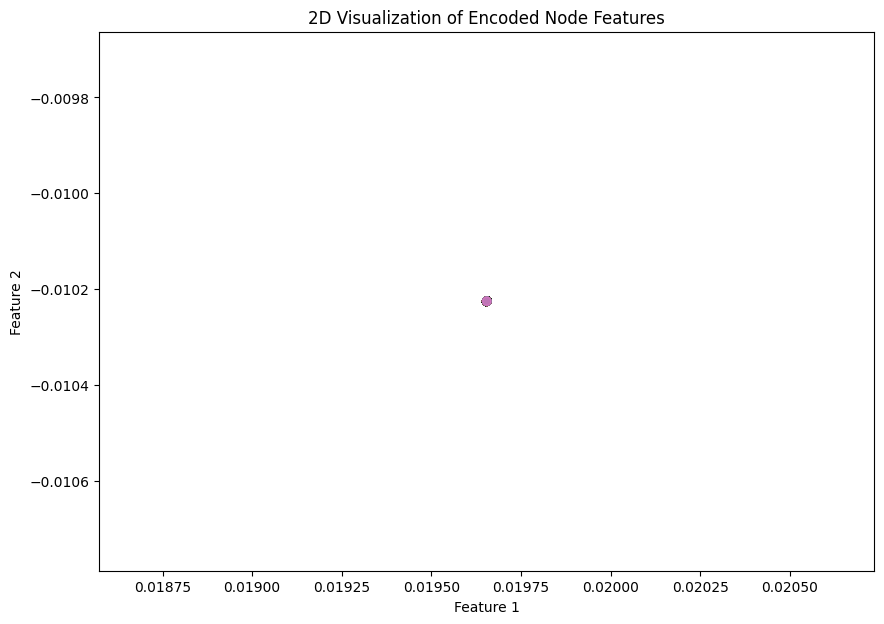

In [12]:
GAE_variant = "basic"
dataset_name = "fMNIST"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [13]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 34.538780212402344
Epoch: 20, Loss: 34.538780212402344
Epoch: 30, Loss: 34.538780212402344
Epoch: 40, Loss: 34.538780212402344
Epoch: 50, Loss: 34.538780212402344
Epoch: 60, Loss: 34.538780212402344
Epoch: 70, Loss: 34.538780212402344
Epoch: 80, Loss: 34.538780212402344
Epoch: 90, Loss: 34.538780212402344
Epoch: 100, Loss: 34.538780212402344
Epoch: 110, Loss: 34.538780212402344
Epoch: 120, Loss: 34.538780212402344
Epoch: 130, Loss: 34.538780212402344
Epoch: 140, Loss: 34.538780212402344
Epoch: 150, Loss: 34.538780212402344
Epoch: 160, Loss: 34.538780212402344
Epoch: 170, Loss: 34.538780212402344
Epoch: 180, Loss: 34.538780212402344
Epoch: 190, Loss: 34.538780212402344
Epoch: 200, Loss: 34.538780212402344


## 

Calculating d_hd
fMNIST GAE-basic + tSNE


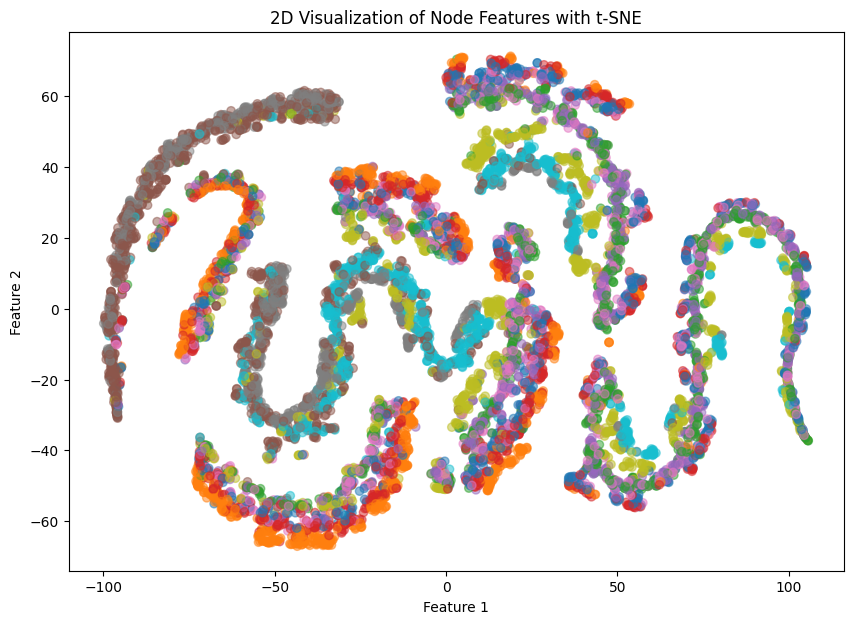

In [15]:
GAE_variant = "basic + tSNE"

local_metrics_tsne = LocalMetric()

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [16]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 34.51652526855469
Epoch: 20, Loss: 26.35918617248535
Epoch: 30, Loss: 15.904362678527832
Epoch: 40, Loss: 4.4319915771484375
Epoch: 50, Loss: 1.3661978244781494
Epoch: 60, Loss: 1.3323867321014404
Epoch: 70, Loss: 1.2968555688858032
Epoch: 80, Loss: 1.2535518407821655
Epoch: 90, Loss: 1.1927402019500732
Epoch: 100, Loss: 1.1512749195098877
Epoch: 110, Loss: 1.114433765411377
Epoch: 120, Loss: 1.099256992340088
Epoch: 130, Loss: 1.082858681678772
Epoch: 140, Loss: 1.0831661224365234
Epoch: 150, Loss: 1.072643518447876
Epoch: 160, Loss: 1.0700010061264038
Epoch: 170, Loss: 1.0654058456420898
Epoch: 180, Loss: 1.0689976215362549
Epoch: 190, Loss: 1.1129858493804932
Epoch: 200, Loss: 1.0742162466049194


## 

Calculating d_hd
fMNIST GAE-basic + tSNE


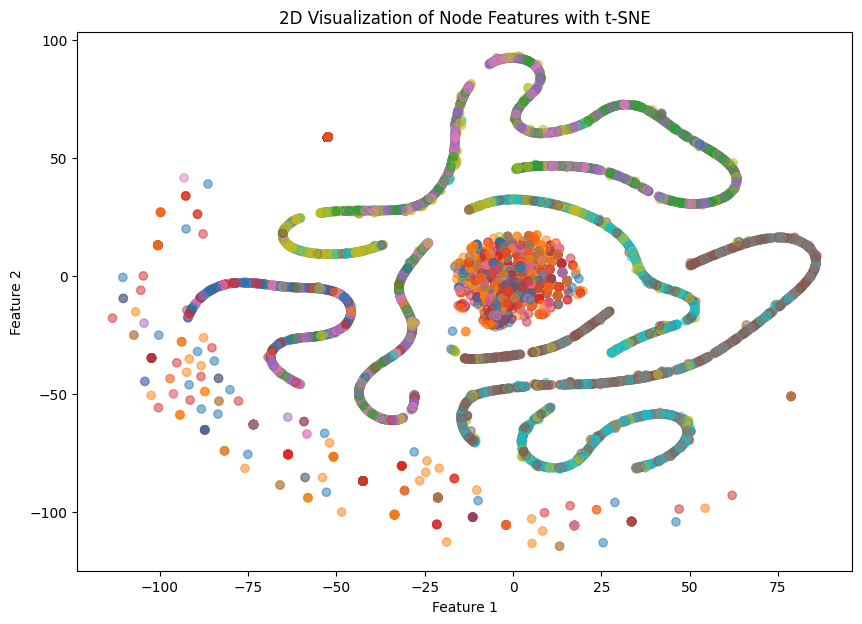

In [18]:
GAE_variant = "basic + tSNE"

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [19]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862708806991577
Epoch: 20, Loss: 1.3862649202346802
Epoch: 30, Loss: 1.386260986328125
Epoch: 40, Loss: 1.3862568140029907
Epoch: 50, Loss: 1.3862531185150146
Epoch: 60, Loss: 1.3862481117248535
Epoch: 70, Loss: 1.3862426280975342
Epoch: 80, Loss: 1.386235237121582
Epoch: 90, Loss: 1.3862279653549194
Epoch: 100, Loss: 1.3862171173095703


## 

Calculating d_hd
fMNIST GAE-skip cons


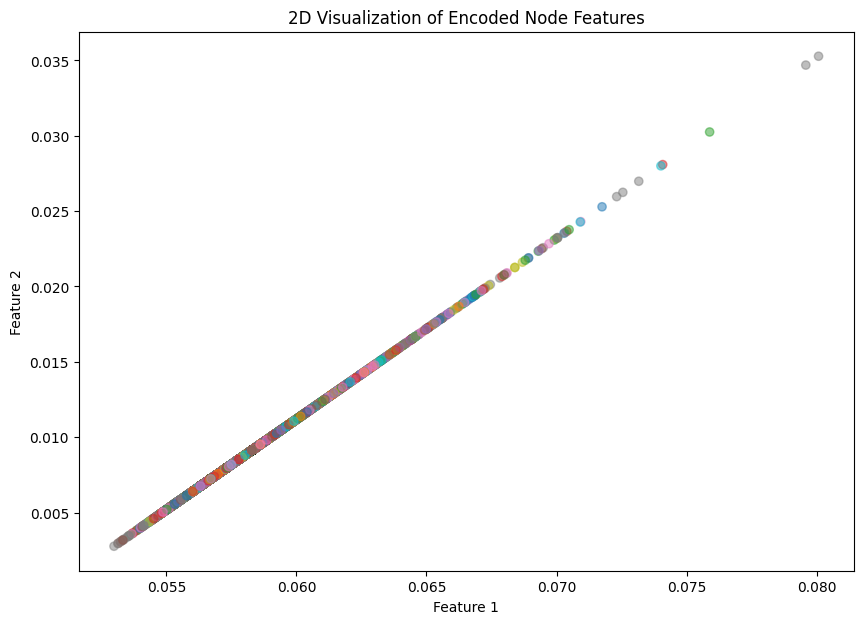

In [21]:
GAE_variant = "skip cons"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')



# 8. Graph AE with attention
Two GATConv layers.

## 

In [22]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 10.05561637878418
Epoch: 20, Loss: 7.691381454467773
Epoch: 30, Loss: 6.931241512298584
Epoch: 40, Loss: 7.142995834350586
Epoch: 50, Loss: 6.921372890472412
Epoch: 60, Loss: 6.826929569244385
Epoch: 70, Loss: 6.734037399291992
Epoch: 80, Loss: 6.696612358093262
Epoch: 90, Loss: 6.7621049880981445
Epoch: 100, Loss: 6.727522850036621
Epoch: 110, Loss: 6.896873474121094
Epoch: 120, Loss: 6.7553558349609375
Epoch: 130, Loss: 6.631481170654297
Epoch: 140, Loss: 6.700067043304443
Epoch: 150, Loss: 6.8364763259887695
Epoch: 160, Loss: 6.563256740570068
Epoch: 170, Loss: 6.598530292510986
Epoch: 180, Loss: 6.74281120300293
Epoch: 190, Loss: 6.619134902954102
Epoch: 200, Loss: 6.506133079528809


## 

Calculating d_hd
fMNIST GAE-attention


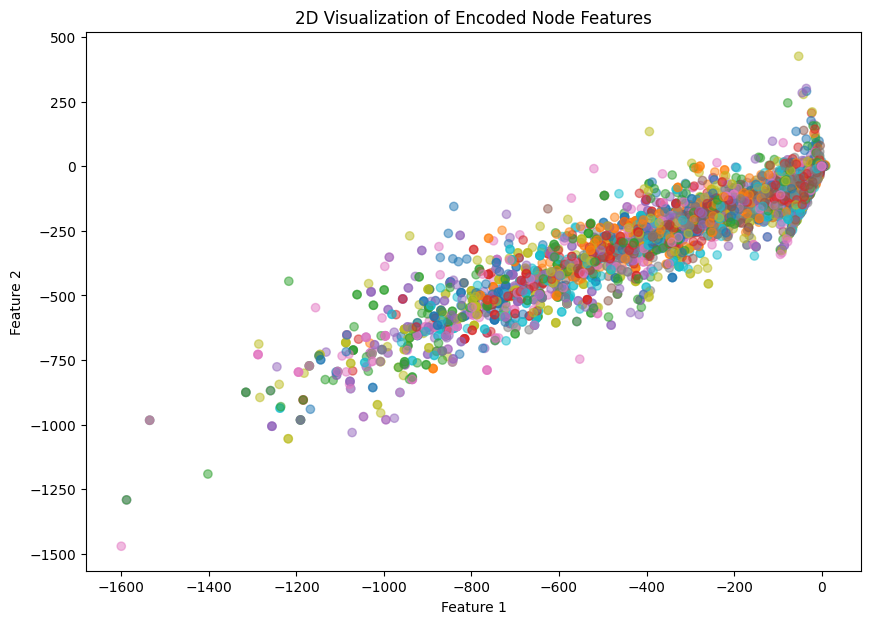

In [24]:
GAE_variant = "attention"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [25]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 7.602299213409424
Epoch: 20, Loss: 6.975214958190918
Epoch: 30, Loss: 6.096406936645508
Epoch: 40, Loss: 6.099632263183594
Epoch: 50, Loss: 5.773027420043945
Epoch: 60, Loss: 6.124915599822998
Epoch: 70, Loss: 5.934314727783203
Epoch: 80, Loss: 5.959652900695801
Epoch: 90, Loss: 6.4542622566223145
Epoch: 100, Loss: 7.592263221740723
Epoch: 110, Loss: 6.611855506896973
Epoch: 120, Loss: 6.277225494384766
Epoch: 130, Loss: 6.227187156677246
Epoch: 140, Loss: 5.846333026885986
Epoch: 150, Loss: 6.401536464691162
Epoch: 160, Loss: 6.037631511688232
Epoch: 170, Loss: 6.115583419799805
Epoch: 180, Loss: 7.565481185913086
Epoch: 190, Loss: 6.214066982269287
Epoch: 200, Loss: 6.693359375


## 

Calculating d_hd
fMNIST GAE-attention + tSNE


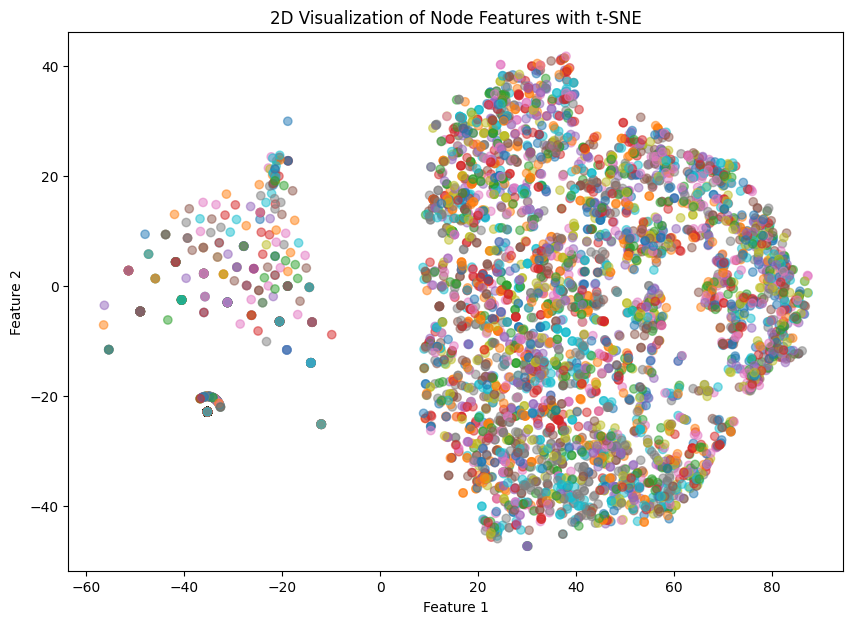

In [27]:
GAE_variant = "attention + tSNE"

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [28]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3801336288452148
Epoch: 20, Loss: 1.307480812072754
Epoch: 30, Loss: 1.2051600217819214
Epoch: 40, Loss: 1.1476162672042847
Epoch: 50, Loss: 1.0869070291519165
Epoch: 60, Loss: 1.059745192527771
Epoch: 70, Loss: 1.049996256828308
Epoch: 80, Loss: 1.038392186164856
Epoch: 90, Loss: 1.040547490119934
Epoch: 100, Loss: 1.03961980342865
Epoch: 110, Loss: 1.0349361896514893
Epoch: 120, Loss: 1.041758418083191
Epoch: 130, Loss: 1.0352669954299927
Epoch: 140, Loss: 1.0337092876434326
Epoch: 150, Loss: 1.0270307064056396
Epoch: 160, Loss: 1.0242449045181274
Epoch: 170, Loss: 1.0287514925003052
Epoch: 180, Loss: 1.021120309829712
Epoch: 190, Loss: 1.0291271209716797
Epoch: 200, Loss: 1.0226068496704102


## 

Calculating d_hd
fMNIST GAE-skip + residual


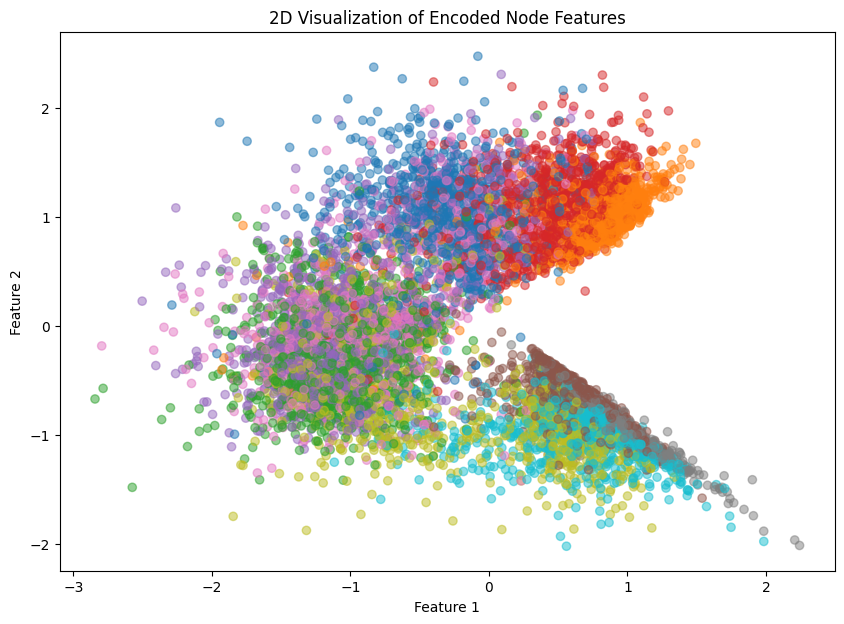

In [30]:
GAE_variant = "skip + residual"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [31]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.9066191911697388
Epoch: 20, Loss: 1.202979326248169
Epoch: 30, Loss: 1.1314741373062134
Epoch: 40, Loss: 1.1192140579223633
Epoch: 50, Loss: 1.0772106647491455
Epoch: 60, Loss: 1.0611861944198608
Epoch: 70, Loss: 1.0529053211212158
Epoch: 80, Loss: 1.043027639389038
Epoch: 90, Loss: 1.0426026582717896
Epoch: 100, Loss: 1.040449857711792
Epoch: 110, Loss: 1.0307358503341675
Epoch: 120, Loss: 1.0349448919296265
Epoch: 130, Loss: 1.035278558731079
Epoch: 140, Loss: 1.0288907289505005
Epoch: 150, Loss: 1.0240784883499146
Epoch: 160, Loss: 1.0280263423919678
Epoch: 170, Loss: 1.0313116312026978
Epoch: 180, Loss: 1.0307648181915283
Epoch: 190, Loss: 1.027991533279419
Epoch: 200, Loss: 1.0211564302444458


## 

Calculating d_hd
fMNIST GAE-residual cons


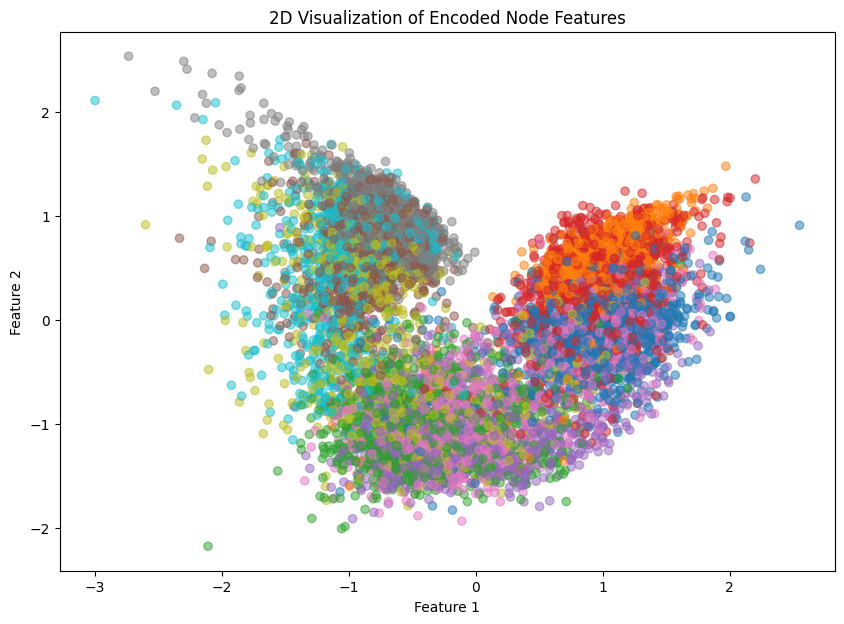

In [33]:
GAE_variant = "residual cons"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [34]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 40000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.357944130897522
Epoch: 20, Loss: 1.3293979167938232
Epoch: 30, Loss: 1.299743413925171
Epoch: 40, Loss: 1.275740146636963
Epoch: 50, Loss: 1.2562849521636963
Epoch: 60, Loss: 1.2447656393051147
Epoch: 70, Loss: 1.2328810691833496
Epoch: 80, Loss: 1.227847933769226
Epoch: 90, Loss: 1.2300848960876465
Epoch: 100, Loss: 1.2121931314468384
Epoch: 110, Loss: 1.2144525051116943
Epoch: 120, Loss: 1.2159098386764526
Epoch: 130, Loss: 1.20749831199646
Epoch: 140, Loss: 1.2089200019836426
Epoch: 150, Loss: 1.2102084159851074
Epoch: 160, Loss: 1.2112703323364258
Epoch: 170, Loss: 1.1977355480194092
Epoch: 180, Loss: 1.203258991241455
Epoch: 190, Loss: 1.2055950164794922
Epoch: 200, Loss: 1.2063026428222656


## 

Calculating d_hd
fMNIST GAE-attention + norm


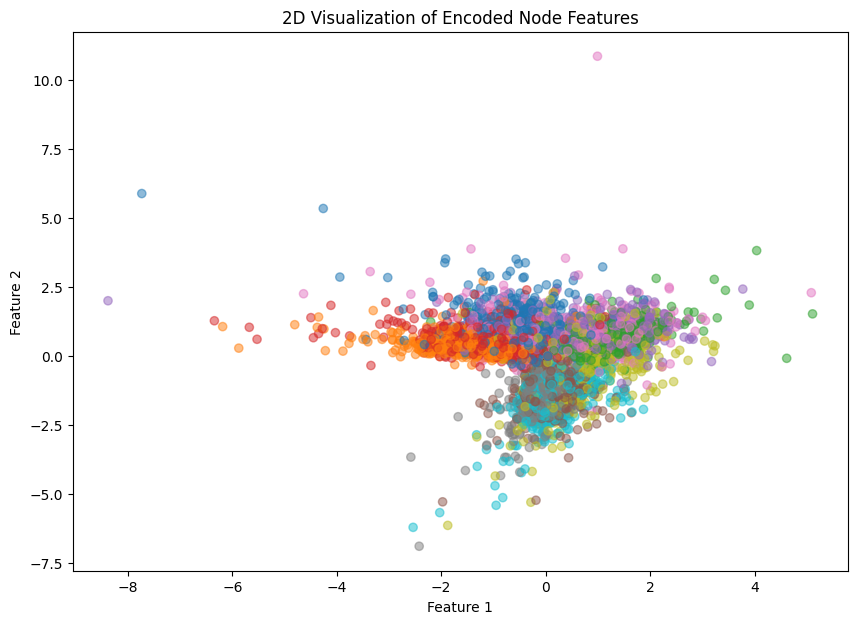

In [36]:
GAE_variant = "attention + norm"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

Finished.


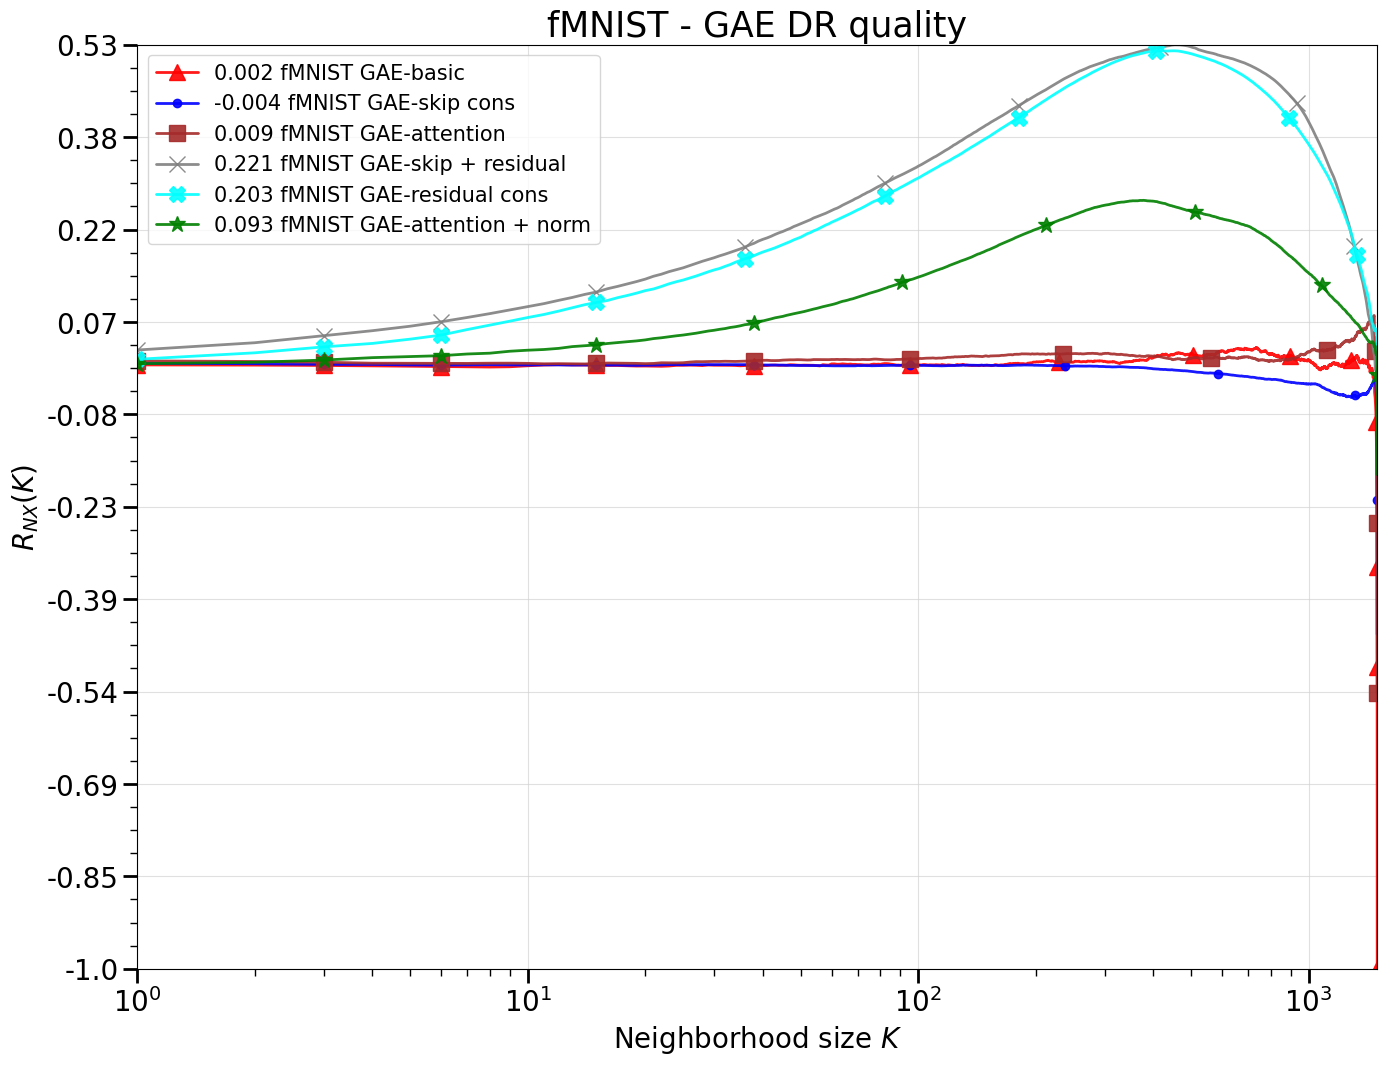

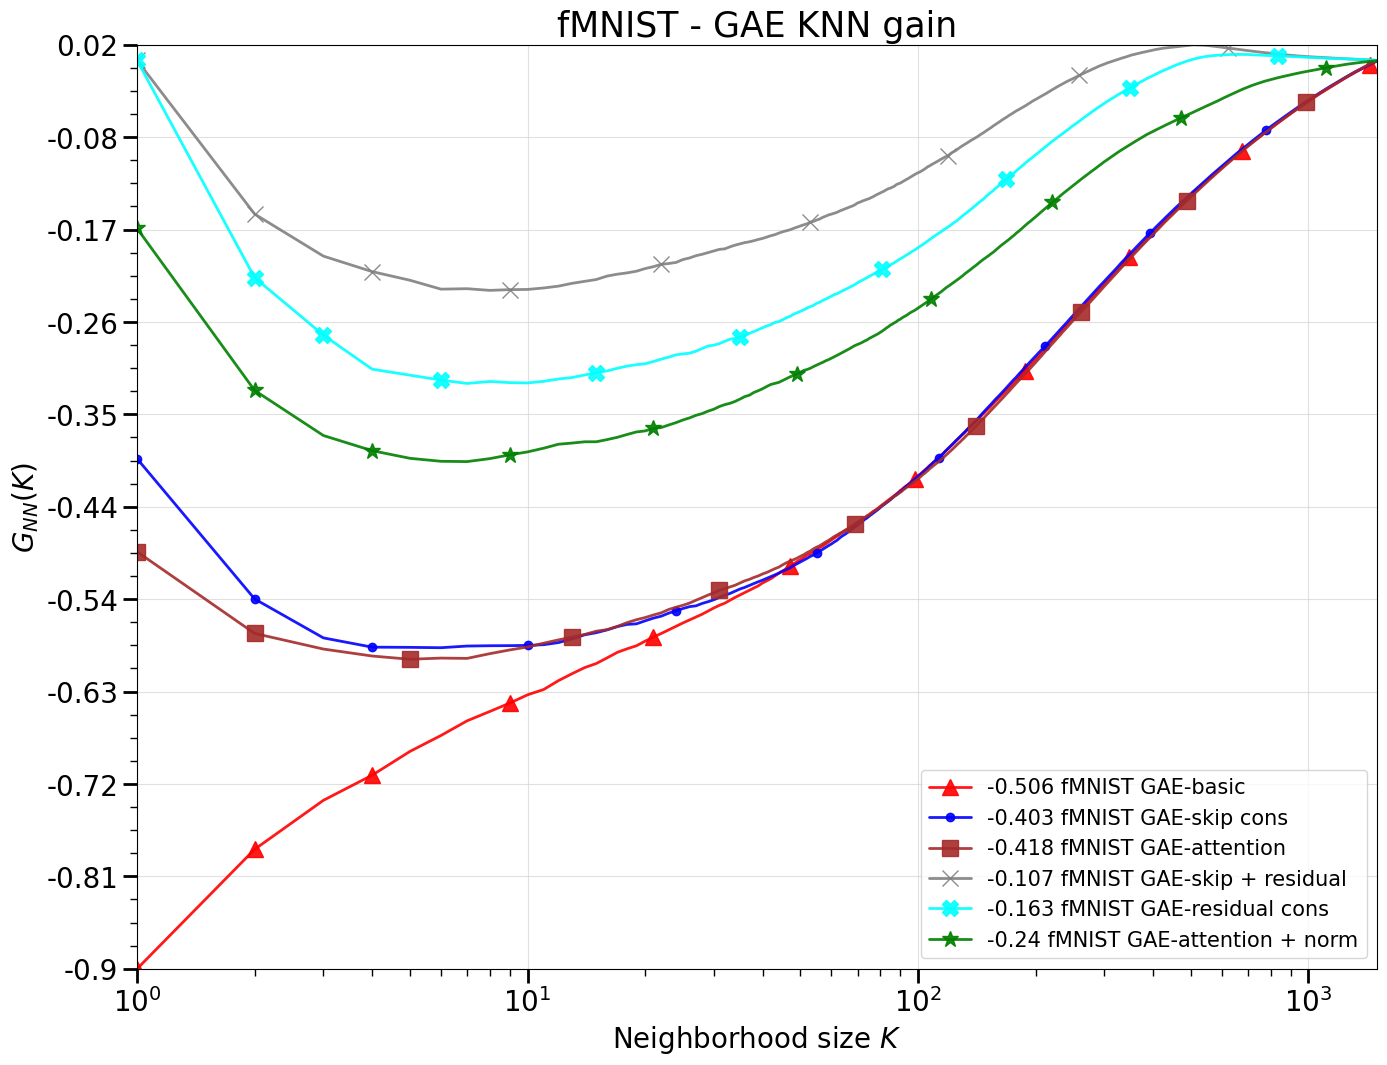

In [37]:
local_metrics.visualize(f"{dataset_name} - {algorithm_name}")

Finished.


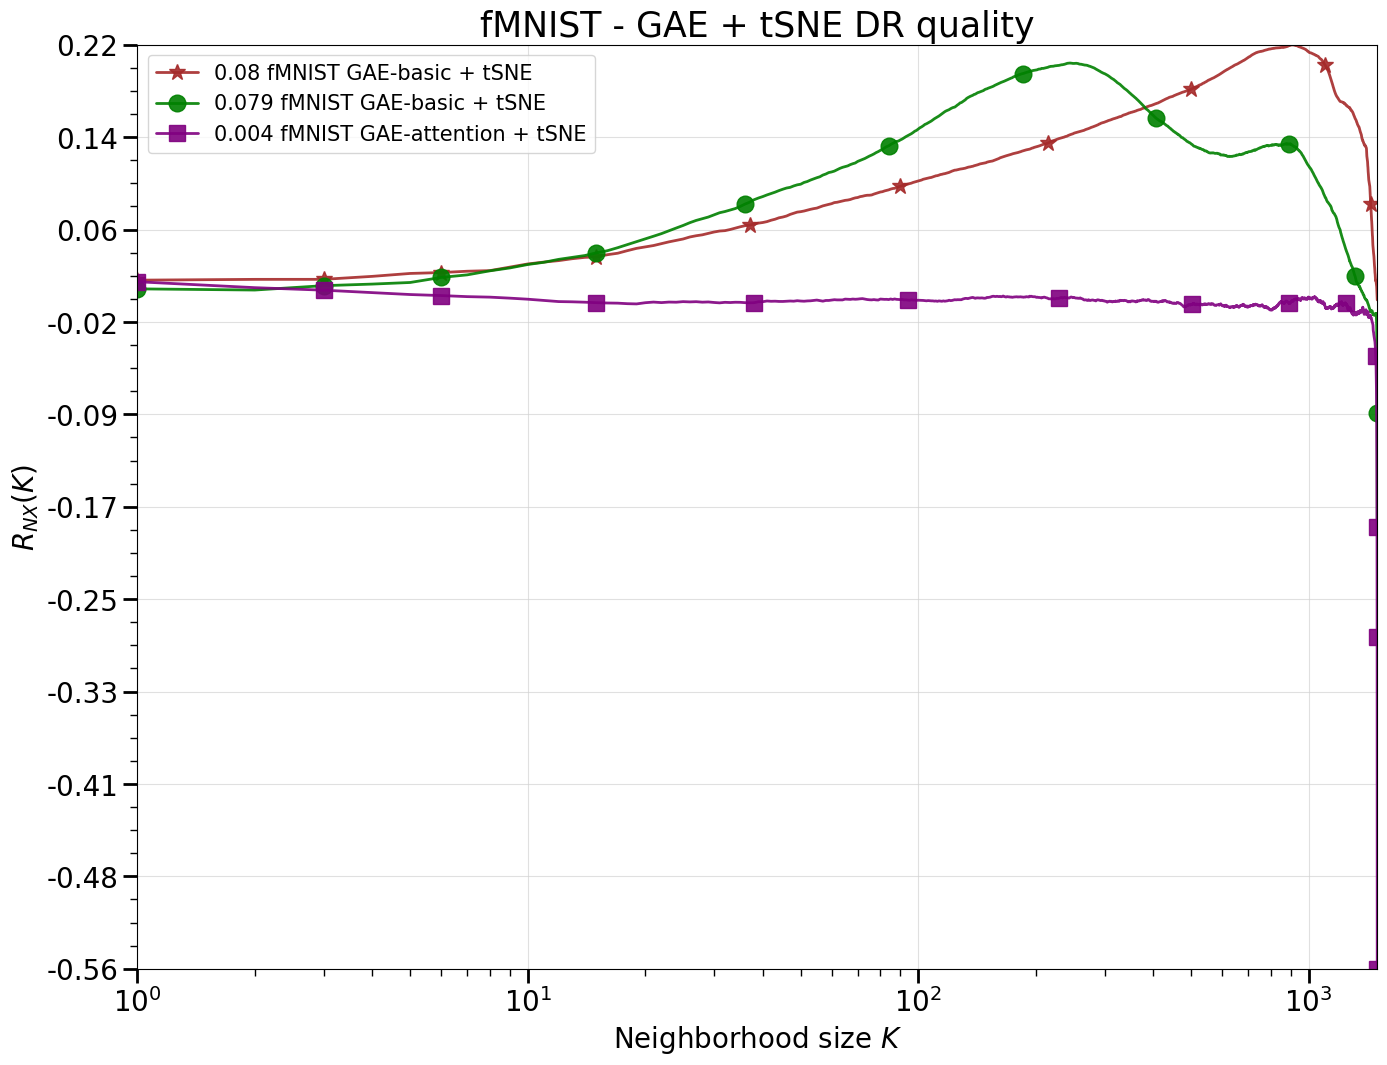

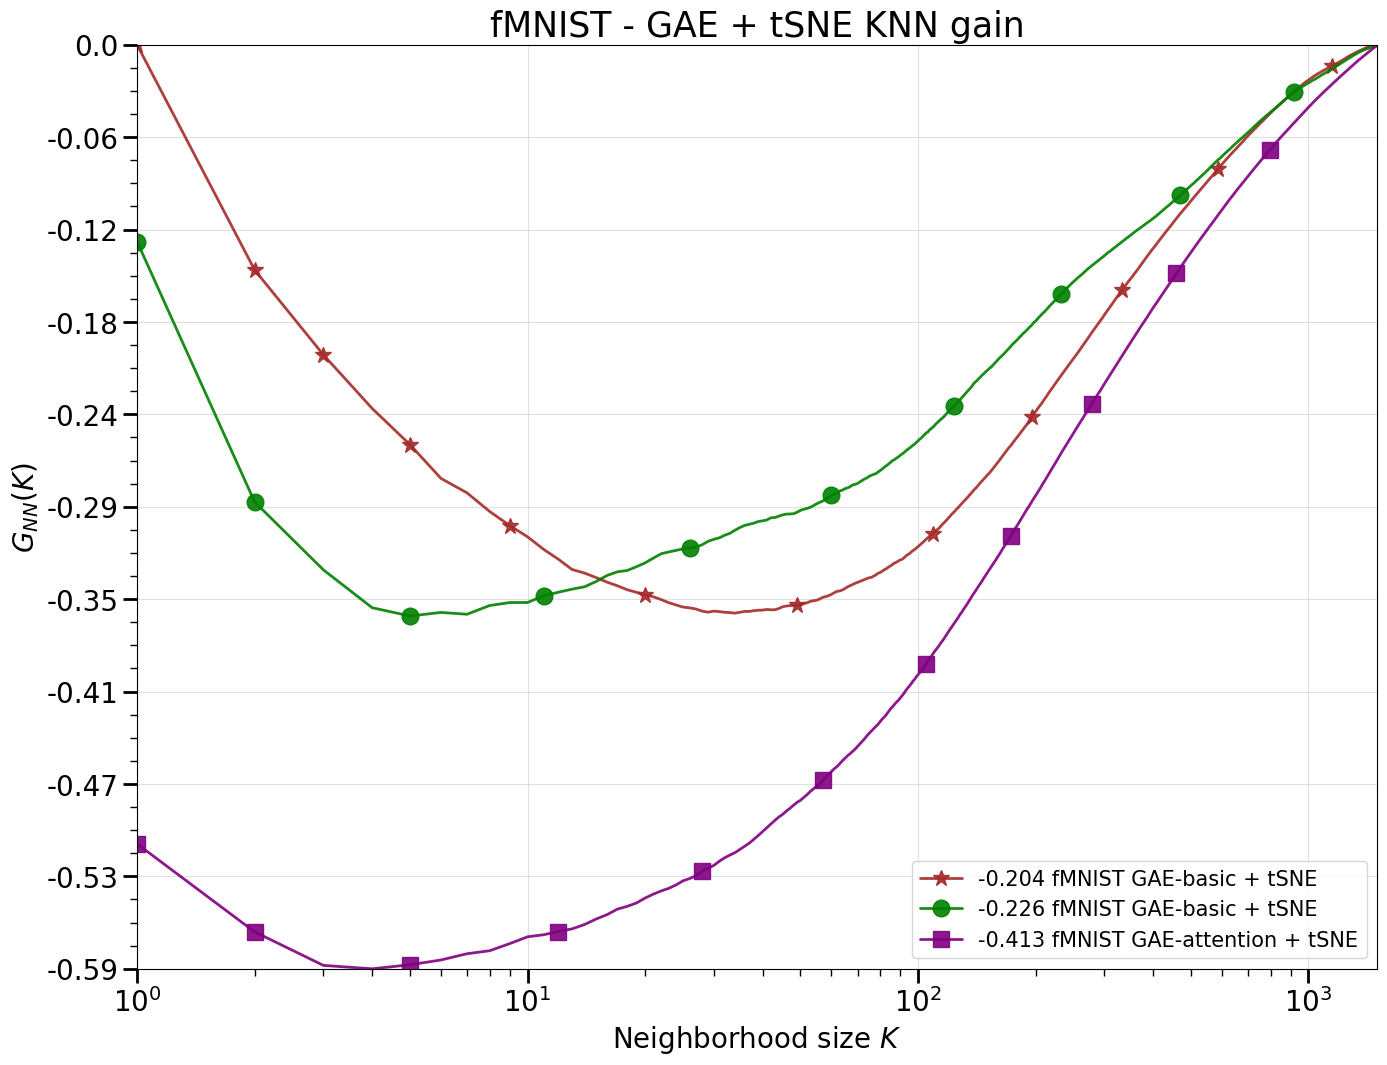

In [38]:
local_metrics_tsne.visualize(f"{dataset_name} - {algorithm_name} + tSNE")